<a href="https://colab.research.google.com/github/hmada179/Brain_tumor_mri_with_CNN/blob/main/Brain_tumor_mri_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D,BatchNormalization,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import EfficientNetB0
from IPython.display import SVG, Image
from sklearn.model_selection import train_test_split
import os
import cv2
import random
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, UnidentifiedImageError
import shutil
from shutil import copyfile
import plotly.express as px
import glob

In [21]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [22]:
print(os.listdir(path))

['Training', 'Testing']


In [23]:
train = path +"/Training"
test = path +'/Testing'

In [24]:
train

'/kaggle/input/brain-tumor-mri-dataset/Training'

In [25]:
len(train)

46

In [26]:
print(os.listdir(train))
print(os.listdir(test))

['pituitary', 'notumor', 'meningioma', 'glioma']
['pituitary', 'notumor', 'meningioma', 'glioma']


In [27]:
def show_sample_images(folder_path, title, num_images=20):
    class_folders = [os.path.join(folder_path, d) for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

    all_images = []

    for class_folder in class_folders:
        image_files = os.listdir(class_folder)
        image_paths = [os.path.join(class_folder, img) for img in image_files if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        all_images.extend(image_paths)

    selected_images = random.sample(all_images, min(num_images, len(all_images)))

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(selected_images):
        img = Image.open(img_path)
        plt.subplot(2, 10, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{os.path.basename(os.path.dirname(img_path))}")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

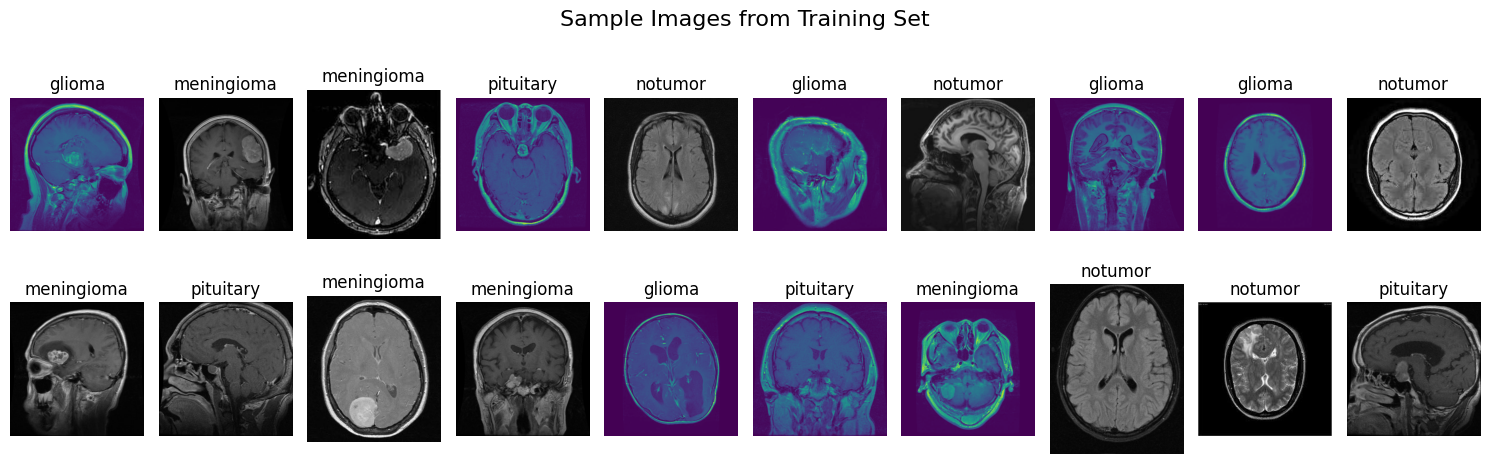

In [28]:
show_sample_images(train, "Sample Images from Training Set")

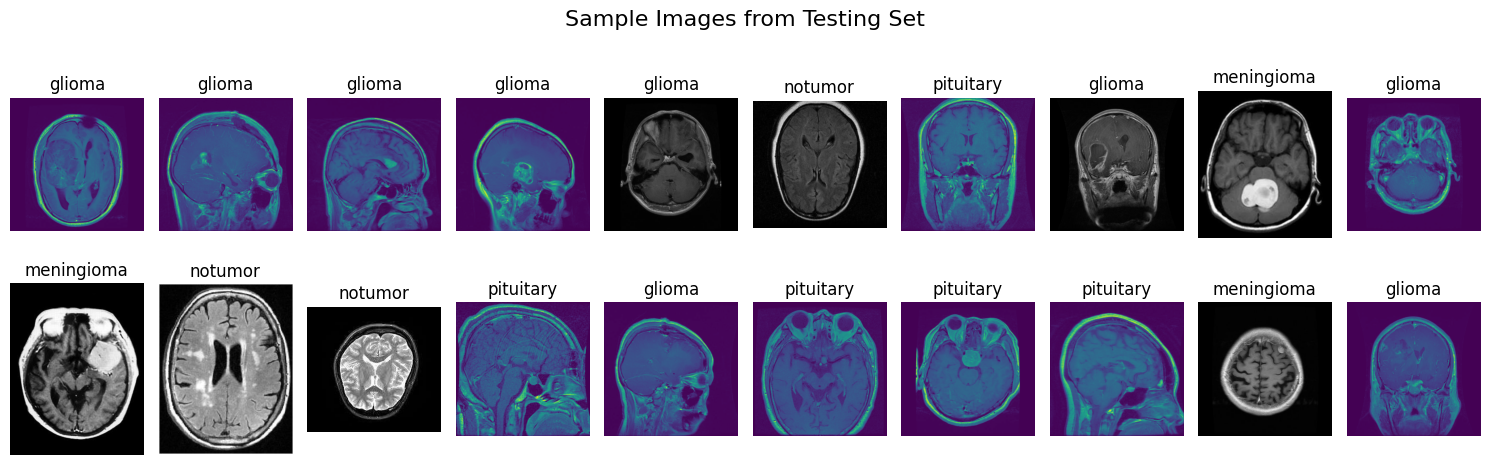

In [29]:
show_sample_images(test, "Sample Images from Testing Set")

In [30]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [31]:
train_generator = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=15,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
    )

test_generator = ImageDataGenerator(rescale=1./255)

In [32]:
train_gen_data = train_generator.flow_from_directory(
    train,
    target_size=(224,224),
    batch_size=16,
    shuffle=True,
    class_mode='categorical',
    subset='training'
)
val_gen_data = train_generator.flow_from_directory(
    train,
    target_size=(224,224),
    batch_size=16,
    shuffle=True,
    class_mode='categorical',
    subset='validation'
)

test_gen_data = test_generator.flow_from_directory(
    test,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [33]:
print(train_gen_data.image_shape)
print(val_gen_data.image_shape)
print(test_gen_data.image_shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [34]:
print("num of classes",train_gen_data.num_classes)
print(train_gen_data.class_indices)

num of classes 4
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [35]:
model = Sequential(
[
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape = train_gen_data.image_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv2D(256, (3, 3), activation='relu', padding='same'),
    # BatchNormalization(),
    # MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(train_gen_data.num_classes, activation='softmax')
]
)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,785,540 (98.36 MB)

 Trainable params: 25,785,092 (98.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [37]:
history = model.fit(train_gen_data, validation_data=val_gen_data, epochs=20)

Epoch 1/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.4743 - loss: 12.9354 - val_accuracy: 0.2761 - val_loss: 21.7803
Epoch 2/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 75s 263ms/step - accuracy: 0.4939 - loss: 1.4713 - val_accuracy: 0.2708 - val_loss: 3.2331
Epoch 3/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 76s 265ms/step - accuracy: 0.5103 - loss: 1.2203 - val_accuracy: 0.4575 - val_loss: 1.2368
Epoch 4/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 81s 261ms/step - accuracy: 0.4930 - loss: 1.4038 - val_accuracy: 0.6004 - val_loss: 1.2182
Epoch 5/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 75s 261ms/step - accuracy: 0.5148 - loss: 1.1086 - val_accuracy: 0.5881 - val_loss: 1.5661
Epoch 6/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 75s 262ms/step - accuracy: 0.5441 - loss: 1.1109 - val_accuracy: 0.4601 - val_loss: 1.3603
Epoch 7/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 74s 260ms/step - accuracy: 0.4910 - loss: 1.1542 - val_accuracy: 0.6126 - val_loss: 2.1433
Epoch 8/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 80s 279ms/step - accuracy: 0.5159 - loss:

In [40]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

Res_model = Model(inputs=base_model.input, outputs=output)

Res_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 23,797,380 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [42]:
Res_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [43]:
Res_history = Res_model.fit(train_gen_data, validation_data= val_gen_data, epochs= 20)

Epoch 1/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 179s 422ms/step - accuracy: 0.6484 - loss: 1.0381 - val_accuracy: 0.2550 - val_loss: 6.4702
Epoch 2/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 92s 322ms/step - accuracy: 0.8203 - loss: 0.5394 - val_accuracy: 0.2270 - val_loss: 7.5402
Epoch 3/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 93s 323ms/step - accuracy: 0.8726 - loss: 0.4080 - val_accuracy: 0.4207 - val_loss: 8.2243
Epoch 4/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 93s 326ms/step - accuracy: 0.8834 - loss: 0.3306 - val_accuracy: 0.5408 - val_loss: 2.4090
Epoch 5/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 92s 321ms/step - accuracy: 0.8889 - loss: 0.3530 - val_accuracy: 0.2673 - val_loss: 6.6651
Epoch 6/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 88s 309ms/step - accuracy: 0.8781 - loss: 0.3598 - val_accuracy: 0.5469 - val_loss: 2.0352
Epoch 7/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 95s 331ms/step - accuracy: 0.9117 - loss: 0.2697 - val_accuracy: 0.7774 - val_loss: 1.1317
Epoch 8/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 89s 311ms/step - accuracy: 0.9095 - loss: 

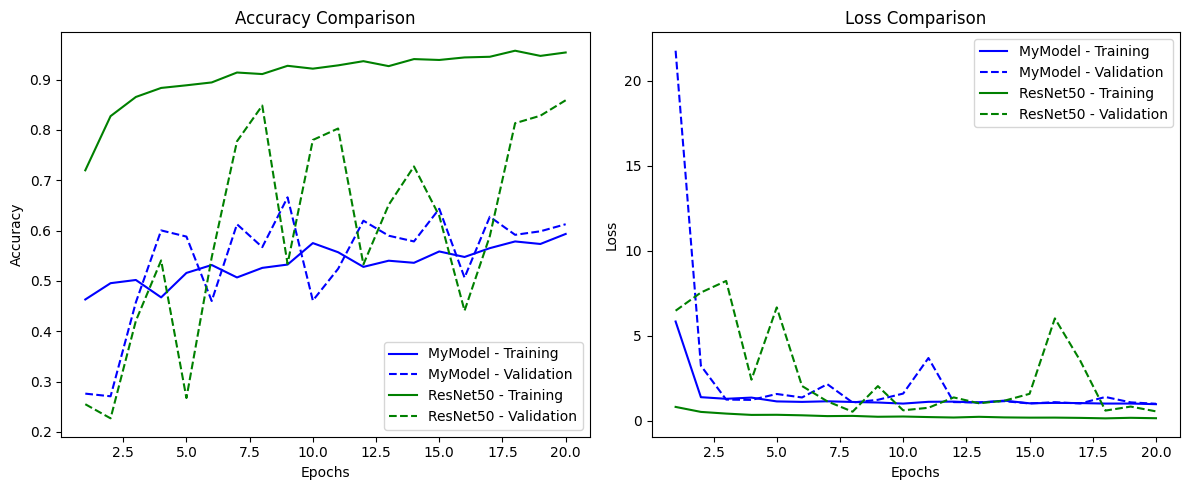

In [44]:
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], 'b', label='MyModel - Training')
plt.plot(epochs, history.history['val_accuracy'], 'b--', label='MyModel - Validation')
plt.plot(epochs, Res_history.history['accuracy'], 'g', label='ResNet50 - Training')
plt.plot(epochs, Res_history.history['val_accuracy'], 'g--', label='ResNet50 - Validation')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], 'b', label='MyModel - Training')
plt.plot(epochs, history.history['val_loss'], 'b--', label='MyModel - Validation')
plt.plot(epochs, Res_history.history['loss'], 'g', label='ResNet50 - Training')
plt.plot(epochs, Res_history.history['val_loss'], 'g--', label='ResNet50 - Validation')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()